<a href="https://colab.research.google.com/github/Sharma-Pranav/Tensorflow_Training/blob/master/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install imageio

In [0]:
import tensorflow as tf
tf.enable_eager_execution()

In [0]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time

from IPython import display

In [0]:
(train_images, train_labels), (_,_) = tf.keras.datasets.mnist.load_data()

In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

In [0]:
train_images = (train_images - 127.5)/127.5

In [0]:
buffer_size = 60000
batch_size = 256


In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

In [0]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(7*7*256, use_bias = False, input_shape = (100, )))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())
  
  model.add(tf.keras.layers.Reshape((7,7,256)))
  assert model.output_shape == (None, 7, 7, 256)
  
  model.add(tf.keras.layers.Conv2DTranspose(128, (5,5), strides = (1,1), padding = 'same', use_bias = False))
  
  assert model.output_shape == (None, 7, 7, 128)  
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)    
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
      
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
       
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
     
    return model

In [0]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [0]:
def generator_loss(generated_output):
  return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), generated_output)

In [0]:
def discriminator_loss(real_output, generated_output):
  real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels = tf.ones_like(real_output), logits = real_output)
  generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.zeros_like(generated_output), logits=generated_output)
  total_loss = real_loss + generated_loss
  return total_loss

In [0]:
generator_optimizer = tf.train.AdamOptimizer(1e-4)
discriminator_optimizer = tf.train.AdamOptimizer(1e-4)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
epochs = 50 
noise_dim = 100
num_examples_to_generate = 16

random_vector_for_generation = tf.random_normal([num_examples_to_generate, noise_dim])

In [0]:
def train_step(images):
   # generating noise from a normal distribution
      noise = tf.random_normal([batch_size, noise_dim])
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
      
        real_output = discriminator(images, training=True)
        generated_output = discriminator(generated_images, training=True)
         
        gen_loss = generator_loss(generated_output)
        disc_loss = discriminator_loss(real_output, generated_output)
        
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)
      
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))

In [0]:
train_step = tf.contrib.eager.defun(train_step)

In [0]:
def train(dataset, epochs):  
  for epoch in range(epochs):
    start = time.time()
    
    for images in dataset:
      train_step(images)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                               epoch + 1,
                               random_vector_for_generation)
    
    # saving (checkpoint) the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print ('Time taken for epoch {} is {} sec'.format(epoch + 1,
                                                      time.time()-start))
  # generating after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           random_vector_for_generation)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # make sure the training parameter is set to False because we
  # don't want to train the batchnorm layer when doing inference.
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))
  
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
        
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

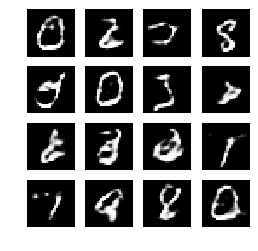

CPU times: user 2min 23s, sys: 39.7 s, total: 3min 3s
Wall time: 9min 57s


In [45]:
%%time
train(train_dataset, epochs)

In [46]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [0]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

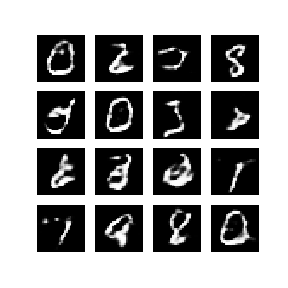

In [48]:
display_image(epochs)

In [49]:
with imageio.get_writer('dcgan.gif', mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
    
# this is a hack to display the gif inside the notebook
os.system('cp dcgan.gif dcgan.gif.png')

0

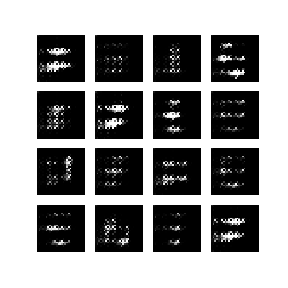

In [50]:
display.Image(filename="dcgan.gif.png")

In [0]:
from google.colab import files
files.download('dcgan.gif')